<a href="https://colab.research.google.com/github/NathanielRose/eeg-294/blob/master/Project_Report_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install git+git://github.com/gumpy-bci/gumpy.git

  Cloning git://github.com/gumpy-bci/gumpy.git to /tmp/pip-req-build-ybekaw6h
  Running command git clone -q git://github.com/gumpy-bci/gumpy.git /tmp/pip-req-build-ybekaw6h
  Created wheel for gumpy: filename=gumpy-0.5.0-cp36-none-any.whl size=32999 sha256=bc3b12073412ab51c1713eac287ddc7834a7a29ad847be666f6184e45a4601e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_o3odj1/wheels/cf/ee/4d/dfa04a0d04ffb1ca36f436f3fef4817e9e23bfec03dd772913
Successfully built gumpy


In [2]:
!git clone https://github.com/NathanielRose/eeg-294.git

Cloning into 'eeg-294'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 194 (delta 78), reused 89 (delta 13), pack-reused 0
Receiving objects: 100% (194/194), 2.54 MiB | 4.92 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [3]:
##Import packages##

%reset
%matplotlib inline

from __future__ import print_function
import os; os.environ["THEANO_FLAGS"] = "device=gpu0"
import os.path
from datetime import datetime
import sys

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
##import gumpy modules##
sys.path.append('gumpy/gumpy/')
import gumpy

sys.path.append('eeg-294/gumpy-deeplearning')
import models

sys.path.append('eeg-294/gumpy-deeplearning/models/')
import utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [0]:
##Setup parameters##
DEBUG = True
CLASS_COUNT = 2
DROPOUT = 0.2   # dropout rate in float

# parameters for filtering data
FS = 250
LOWCUT = 2
HIGHCUT = 60
ANTI_DRIFT = 0.5
CUTOFF = 50.0 # freq to be removed from signal (Hz) for notch filter
Q = 30.0  # quality factor for notch filter 
W0 = CUTOFF/(FS/2)
AXIS = 0

#set random seed
SEED = 42
KFOLD = 5

# Get Data

In [6]:
%%bash
%%capture 

export fileid=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
export filename=grazdata.zip


wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

wget --load-cookies cookies.txt -O $filename \
     'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)

bash: line 1: fg: no job control
--2019-12-19 19:47:31--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
Resolving docs.google.com (docs.google.com)... 74.125.20.113, 74.125.20.101, 74.125.20.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

     0K ...                                                    16.7M=0s

2019-12-19 19:47:31 (16.7 MB/s) - written to stdout [3247]

--2019-12-19 19:47:31--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb&confirm=GocS
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.113, 74.125.142.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksu

In [7]:
!unzip grazdata.zip

Archive:  grazdata.zip
mapname:  conversion of  failed
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [8]:
!unzip grazdata

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [9]:
#load data
subj = 'B01'

grazb_data = gumpy.data.GrazB('', subj)
grazb_data.load()


In [10]:
grazb_data.print_stats()

Data identification: GrazB-B01
EEG-data shape: (1626266, 3)
Trials data shape:  (324,)
Labels shape:  (324,)
Total length of single trial:  8
Sampling frequency of EEG data: 250
Interval for motor imagery in trial:  [4, 7]
Classes possible:  [0 1]


# Functions

In [0]:
#train data follos format [x, y].  Same with val_data
def run_model(model, model_name, epochs, train_data, val_split, batch_size, monitor_index):
    # save best weights
    if os.path.isdir('logs'):
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    else:
      os.mkdir('logs')
      log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
    checkpointer = ModelCheckpoint('checkpoints/' + '%s.h5'%model_name, monitor=monitor_index, verbose=1,save_best_only=True, mode='auto', period=1)
    

    # stop if the model does not improve for 15 epoches
    stoppointer = EarlyStopping(monitor=monitor_index, min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # run model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                   shuffle=True,
                   batch_size=batch_size, validation_split = val_split,
                   callbacks=[checkpointer, stoppointer], verbose=2)
    return history


#saves model to json file saves model weights to h5 file
def save_model(model, model_name, working_dir):

    model_json = model.to_json()
    if os.path.isdir('models'):
      # save model to json
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)
    else:
      os.mkdir('models')
      with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)

    #save model weights
    model.save_weights(working_dir +'models/' + '%s_weights.h5'%model_name)

# draw the training curves
def draw_graphs(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

# sCNN

## og sCNN

In [0]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Conv2D, Dropout, BatchNormalization, \
                         Reshape, Activation, Flatten, AveragePooling2D, Conv3D

In [12]:
# now that the dataset is setup, we can load the data. This will be handled from within the utils function, 
# which will first load the data and subsequently filter it using a notch and a bandpass filter.
# the utility function will then return the training data.
x_train, y_train = utils.load_preprocess_data(grazb_data, True, LOWCUT, HIGHCUT, W0, Q, ANTI_DRIFT, CLASS_COUNT, CUTOFF, AXIS, FS)

Band-pass filtering the data in frequency range from 2.0 Hz to 60.0 Hz... 
Data loaded and processed successfully!


In [54]:
#Augment Data
x_augmented, y_augmented = gumpy.signal.sliding_window(data = x_train[:,:,:],
                                                          labels = y_train[:,:],
                                                          window_sz = 4 * FS,
                                                          n_hop = FS // 10,
                                                          n_start = FS * 1)
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)
x_subject = np.rollaxis(x_subject, 1)
x_subject = np.rollaxis(x_subject, 2, 1)



(10044, 2)

In [65]:
x_subject = x_augmented
y_subject = y_augmented
x_subject = np.rollaxis(x_subject, 2, 1)
# x_subject = np.rollaxis(x_subject, 1)
# x_subject = np.rollaxis(x_subject, 2, 1)
x_subject.shape

(10044, 3, 1000)

In [66]:
x_subject = np.expand_dims(x_subject, axis =3)
x_subject.shape

(10044, 3, 1000, 1)

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=40, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 40, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=40, kernel_size=(3, 1, 40), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 40, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 3, 976, 40)        1040      
_________________________________________________________________
reshape_19 (Reshape)         (None, 3, 976, 40, 1)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 1, 976, 1, 40)     4840      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 976, 1, 40)     160       
_________________________________________________________________
activation_19 (Activation)   (None, 1, 976, 1, 40)     0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 39040)             0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 976, 40, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.2155 - acc: 0.9163 - val_loss: 1.2668 - val_acc: 0.5249

Epoch 00001: val_loss improved from inf to 1.26677, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 2/100
 - 47s - loss: 0.2098 - acc: 0.9161 - val_loss: 1.0650 - val_acc: 0.5808

Epoch 00002: val_loss improved from 1.26677 to 1.06497, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 3/100
 - 47s - loss: 0.1934 - acc: 0.9220 - val_loss: 0.7508 - val_acc: 0.7052

Epoch 00003: val_loss improved from 1.06497 to 0.75080, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 4/100
 - 47s - loss: 0.1834 - acc: 0.9282 - val_loss: 1.2760 - val_acc: 0.5137

Epoch 00004: val_loss did not improve from 0.75080
Epoch 5/100
 - 46s - loss: 0.1665 - acc: 0.9394 - val_loss: 0.6120 - val_acc: 0.7724

Epoch 00005: val_loss improved from 0.75080 to 0.61198, saving model to checkpoints/GRAZ_sCNN__run_1.h5
Epoch 6/100
 - 46s - loss: 0.1834 - acc: 0.9256 - v

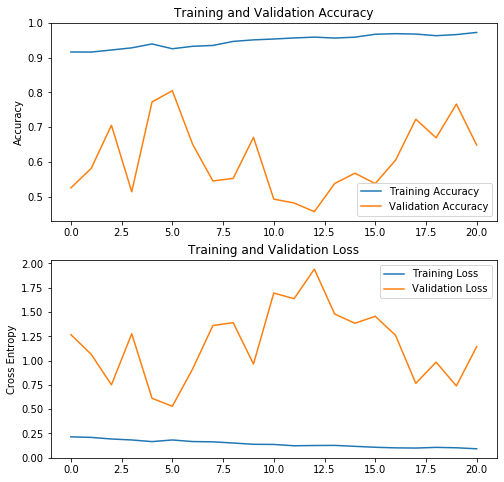

Training Acc:  [0.9163324575077332, 0.9160558705820514, 0.9220024893234716, 0.9282256949658447, 0.9394274651386022, 0.9255981192254473, 0.9326510856448657, 0.9351403679183007, 0.9467570184177588, 0.9511824090967796, 0.953671691345486, 0.9567141474620416, 0.9590651362520286, 0.9564375605363599, 0.9589268427685804, 0.9673627437669498, 0.9690222652633397, 0.9679159175853416, 0.9632139400136106, 0.966394689547671, 0.9726178951982871]



Evaluating model on test set...
Result on test set: 89.70%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1812 - acc: 0.9267 - val_loss: 0.0782 - val_acc: 0.9751

Epoch 00001: val_loss improved from inf to 0.07824, saving model to checkpoints/GRAZ_sCNN__run_2.h5
Epoch 2/100
 - 47s - loss: 0.1702 - acc: 0.9368 - val_loss: 0.2149 - val_acc: 0.9353

Epoch 00002: val_loss did not improve from 0.07824
Epoch 3/100
 - 47s - loss: 0.1521 - acc: 0.9412 - val_loss: 0.9075 - val_acc: 0.6878

Epoch 00003: val_loss did not improve f

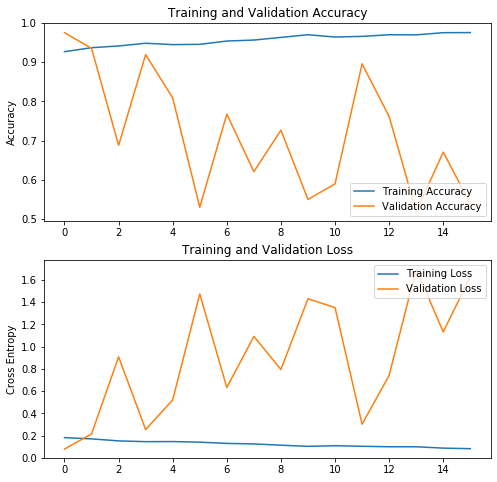

Training Acc:  [0.9267044669364172, 0.9367998894146906, 0.9412252800772256, 0.9481399530131958, 0.944682616512239, 0.9453740838388077, 0.9538099848289342, 0.9562992670529117, 0.9630756465631342, 0.9698520260238991, 0.964043700765927, 0.9657032222870457, 0.9698520259991702, 0.9695754390899743, 0.9751071774387504, 0.975383764389161]



Evaluating model on test set...
Result on test set: 71.13%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1764 - acc: 0.9317 - val_loss: 0.1449 - val_acc: 0.9353

Epoch 00001: val_loss improved from inf to 0.14491, saving model to checkpoints/GRAZ_sCNN__run_3.h5
Epoch 2/100
 - 47s - loss: 0.1529 - acc: 0.9432 - val_loss: 0.1975 - val_acc: 0.9291

Epoch 00002: val_loss did not improve from 0.14491
Epoch 3/100
 - 47s - loss: 0.1530 - acc: 0.9466 - val_loss: 0.1945 - val_acc: 0.9316

Epoch 00003: val_loss did not improve from 0.14491
Epoch 4/100
 - 47s - loss: 0.1395 - acc: 0.9487 - val_loss: 0.5559 - val_acc: 0.7998

Epo

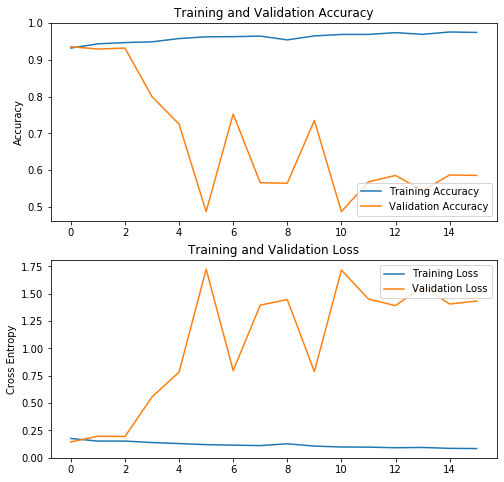

Training Acc:  [0.9316830314255868, 0.943161388532269, 0.9466187249755252, 0.9486931268398304, 0.9575439082143581, 0.9622458857696031, 0.9626607661704901, 0.9641819942328894, 0.9539482783041394, 0.9647351680347953, 0.9687456783459009, 0.9687456783541438, 0.973585949392837, 0.9690222652550967, 0.9753837643561892, 0.9741391232606864]



Evaluating model on test set...
Result on test set: 78.00%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1607 - acc: 0.9376 - val_loss: 0.0756 - val_acc: 0.9701

Epoch 00001: val_loss improved from inf to 0.07556, saving model to checkpoints/GRAZ_sCNN__run_4.h5
Epoch 2/100
 - 46s - loss: 0.1430 - acc: 0.9483 - val_loss: 0.0840 - val_acc: 0.9639

Epoch 00002: val_loss did not improve from 0.07556
Epoch 3/100
 - 46s - loss: 0.1358 - acc: 0.9506 - val_loss: 0.2753 - val_acc: 0.9030

Epoch 00003: val_loss did not improve from 0.07556
Epoch 4/100
 - 47s - loss: 0.1427 - acc: 0.9436 - val_loss: 0.3310 - val_acc: 0.8893

Ep

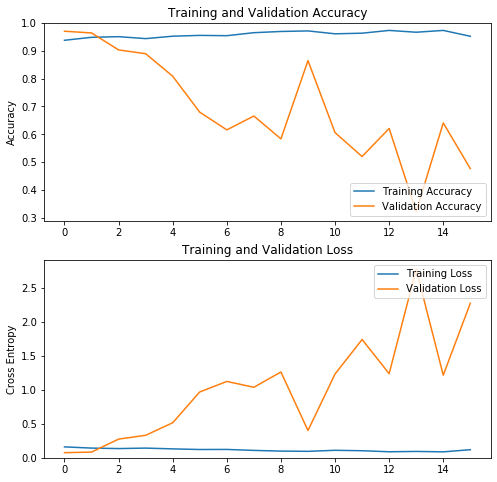

Training Acc:  [0.9376296501422783, 0.9482782464471864, 0.9506292353278455, 0.9435762688836984, 0.9522887567912637, 0.9551929193913994, 0.9540865717216442, 0.9648734615100005, 0.9692988521890215, 0.9712349606028501, 0.9608629512153808, 0.9630756465219195, 0.9730327755744453, 0.9665329829899045, 0.9730327756074171, 0.9520121698490961]



Evaluating model on test set...
Result on test set: 72.47%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 47s - loss: 0.1567 - acc: 0.9407 - val_loss: 0.0324 - val_acc: 0.9851

Epoch 00001: val_loss improved from inf to 0.03242, saving model to checkpoints/GRAZ_sCNN__run_5.h5
Epoch 2/100
 - 47s - loss: 0.1363 - acc: 0.9509 - val_loss: 0.2013 - val_acc: 0.9254

Epoch 00002: val_loss did not improve from 0.03242
Epoch 3/100
 - 46s - loss: 0.1292 - acc: 0.9567 - val_loss: 1.0561 - val_acc: 0.6667

Epoch 00003: val_loss did not improve from 0.03242
Epoch 4/100
 - 47s - loss: 0.1258 - acc: 0.9555 - val_loss: 0.6201 - val_acc: 0.7923



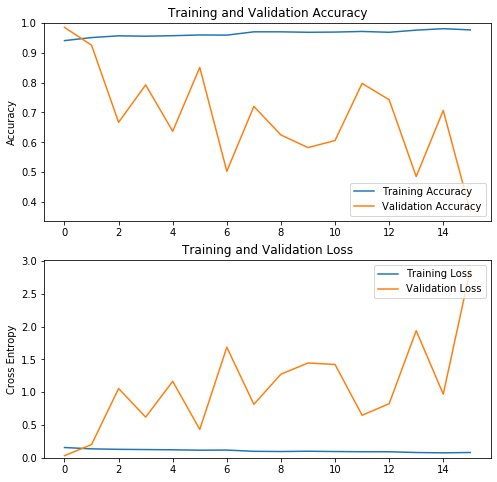

Training Acc:  [0.9406803097345132, 0.9509126106194691, 0.9567201327433629, 0.9554756637168141, 0.9571349557522124, 0.9596238938053098, 0.959070796460177, 0.9701327433628318, 0.9701327433628318, 0.9686117256637168, 0.9693030973451328, 0.9713772123893806, 0.9686117256637168, 0.9758019911504425, 0.980641592920354, 0.9766316371681416]



Evaluating model on test set...
Result on test set: 65.94%
75.45% (+/- 8.09%)
Saving CV values to file....
CV values successfully saved!



In [102]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores = []
history = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores.append(scores[1] * 100)
    ii += 1
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
train_acc = [0.9766316371681416, 0.9520121698490961,  0.9741391232606864, 0.975383764389161,  0.9726178951982871]

In [0]:
cap_df = pd.DataFrame(columns = ['Capacity (bits)', 'CV Train Acc', 'CV Test Acc'])
cap_df.loc['original sCNN', 'CV Test Acc'] = np.mean(cvscores)
cap_df.loc['original sCNN', 'Capacity (bits)'] = 8360
cap_df.loc['original sCNN', 'CV Train Acc'] = np.mean(train_acc)*100


In [125]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
original sCNN,8360,97.0157,75.4471


## our sCNN 2960 bits

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=20, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 20, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=20, kernel_size=(3, 1, 20), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 20, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 3, 976, 20)        520       
_________________________________________________________________
reshape_23 (Reshape)         (None, 3, 976, 20, 1)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 1, 976, 1, 20)     1220      
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 976, 1, 20)     80        
_________________________________________________________________
activation_22 (Activation)   (None, 1, 976, 1, 20)     0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 19520)             0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 976, 20, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 28s - loss: 0.5780 - acc: 0.6916 - val_loss: 0.3481 - val_acc: 0.8669

Epoch 00001: val_loss improved from inf to 0.34811, saving model to checkpoints/GRAZ_sCNN_lowercap_run_1.h5
Epoch 2/100
 - 27s - loss: 0.3822 - acc: 0.8245 - val_loss: 0.9798 - val_acc: 0.4478

Epoch 00002: val_loss did not improve from 0.34811
Epoch 3/100
 - 27s - loss: 0.3319 - acc: 0.8549 - val_loss: 0.7795 - val_acc: 0.6070

Epoch 00003: val_loss did not improve from 0.34811
Epoch 4/100
 - 27s - loss: 0.3010 - acc: 0.8690 - val_loss: 0.3069 - val_acc: 0.8856

Epoch 00004: val_loss improved from 0.34811 to 0.30692, saving model to checkpoints/GRAZ_sCNN_lowercap_run_1.h5
Epoch 5/100
 - 27s - loss: 0.2718 - acc: 0.8899 - val_loss: 0.2041 - val_acc: 0.9328

Epoch 00005: val_loss improved from 0.30692 to 0.20413, saving model to checkpoints/GRAZ_sCNN_lowercap_run_1.h5
Epoch 6/100
 - 27s - loss: 0.2551 - acc: 0.8939 - val_loss: 0.1635 - val_acc: 0.

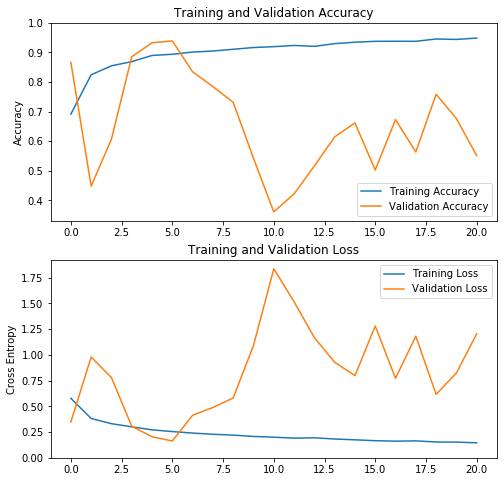

Training Acc:  [0.6916055871546475, 0.8245056009757504, 0.8549301618528043, 0.8690360946339404, 0.8899184069005702, 0.8939289172116758, 0.9013967639660377, 0.9049923939669285, 0.9108007191754429, 0.916747337933349, 0.9196515005169988, 0.923800304278581, 0.920757848194997, 0.9298852164539917, 0.9347254875091708, 0.9377679436504552, 0.9380445305019506, 0.9377679436009977, 0.9456506707727323, 0.9441294427103331, 0.9486931268398304]



Evaluating model on test set...
Result on test set: 80.79%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2453 - acc: 0.9015 - val_loss: 0.0306 - val_acc: 0.9913

Epoch 00001: val_loss improved from inf to 0.03062, saving model to checkpoints/GRAZ_sCNN_lowercap_run_2.h5
Epoch 2/100
 - 27s - loss: 0.2373 - acc: 0.9000 - val_loss: 0.1352 - val_acc: 0.9602

Epoch 00002: val_loss did not improve from 0.03062
Epoch 3/100
 - 27s - loss: 0.2221 - acc: 0.9119 - val_loss: 0.3271 - val_acc: 0.8731

Epoch 00003: val_loss did not im

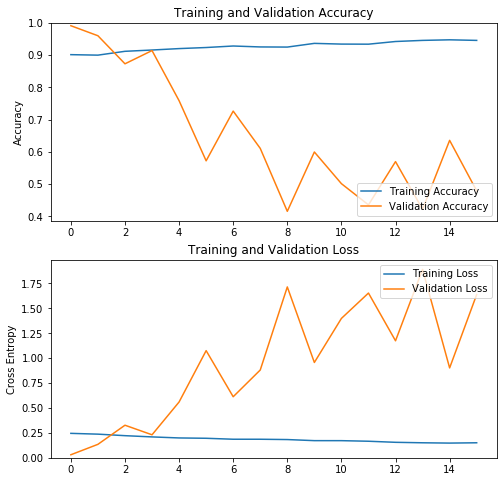

Training Acc:  [0.901535057433, 0.9000138294283012, 0.9119070668122264, 0.915917577131575, 0.9203429678353247, 0.9236620108528333, 0.9283639884163212, 0.9254598257914567, 0.9250449454235414, 0.9365233024972518, 0.9343106071577414, 0.9340340202485455, 0.9423316277222521, 0.94578896419848, 0.9475867791700753, 0.9457889642396947]



Evaluating model on test set...
Result on test set: 65.51%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2361 - acc: 0.9032 - val_loss: 0.0292 - val_acc: 0.9938

Epoch 00001: val_loss improved from inf to 0.02920, saving model to checkpoints/GRAZ_sCNN_lowercap_run_3.h5
Epoch 2/100
 - 27s - loss: 0.2296 - acc: 0.9075 - val_loss: 0.0801 - val_acc: 0.9677

Epoch 00002: val_loss did not improve from 0.02920
Epoch 3/100
 - 27s - loss: 0.2185 - acc: 0.9138 - val_loss: 0.0323 - val_acc: 0.9950

Epoch 00003: val_loss did not improve from 0.02920
Epoch 4/100
 - 27s - loss: 0.2159 - acc: 0.9130 - val_loss: 0.1648 - val_acc: 0.9341


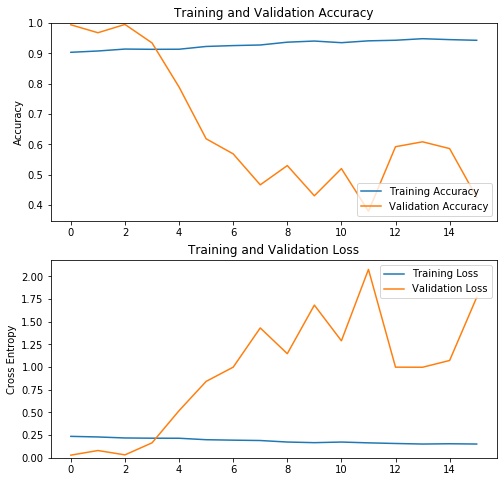

Training Acc:  [0.9031945789706046, 0.9074816761661773, 0.9138431752755127, 0.9130134145067105, 0.9132900014488781, 0.9224173697326016, 0.9253215323492231, 0.9272576407548089, 0.9365233024890088, 0.9402572258909186, 0.9348637809761331, 0.940948693151544, 0.9428848015736155, 0.9480016595379905, 0.9449592034873783, 0.9427465081066532]



Evaluating model on test set...
Result on test set: 65.60%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2320 - acc: 0.9050 - val_loss: 0.0581 - val_acc: 0.9764

Epoch 00001: val_loss improved from inf to 0.05809, saving model to checkpoints/GRAZ_sCNN_lowercap_run_4.h5
Epoch 2/100
 - 27s - loss: 0.2227 - acc: 0.9105 - val_loss: 0.0376 - val_acc: 0.9913

Epoch 00002: val_loss improved from 0.05809 to 0.03761, saving model to checkpoints/GRAZ_sCNN_lowercap_run_4.h5
Epoch 3/100
 - 27s - loss: 0.2181 - acc: 0.9084 - val_loss: 0.2226 - val_acc: 0.9129

Epoch 00003: val_loss did not improve from 0.03761
Epoch 4/100
 - 27s

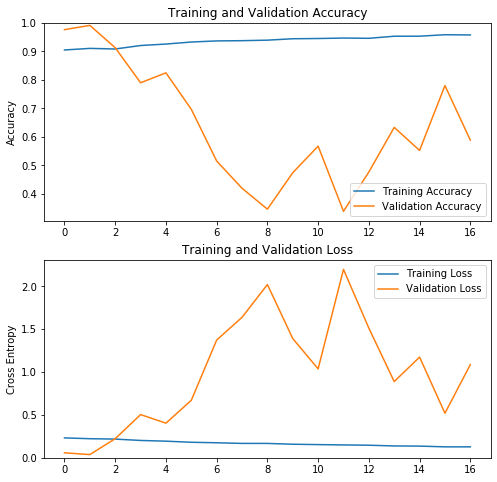

Training Acc:  [0.904992393917471, 0.9105241322497613, 0.9084497304184278, 0.9206195547115488, 0.9257364126759238, 0.9329276725293327, 0.9367998893982048, 0.9376296501422783, 0.9394274651303592, 0.9444060296112861, 0.9452357903718454, 0.9468953118599923, 0.9459272576736854, 0.9532568109693278, 0.9533951044198042, 0.958511962417151, 0.9578204950988252]



Evaluating model on test set...
Result on test set: 68.69%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 27s - loss: 0.2115 - acc: 0.9144 - val_loss: 0.3299 - val_acc: 0.8557

Epoch 00001: val_loss improved from inf to 0.32993, saving model to checkpoints/GRAZ_sCNN_lowercap_run_5.h5
Epoch 2/100
 - 27s - loss: 0.2047 - acc: 0.9168 - val_loss: 0.2213 - val_acc: 0.9005

Epoch 00002: val_loss improved from 0.32993 to 0.22131, saving model to checkpoints/GRAZ_sCNN_lowercap_run_5.h5
Epoch 3/100
 - 27s - loss: 0.1903 - acc: 0.9264 - val_loss: 0.2757 - val_acc: 0.8893

Epoch 00003: val_loss did not improve from 0.22131

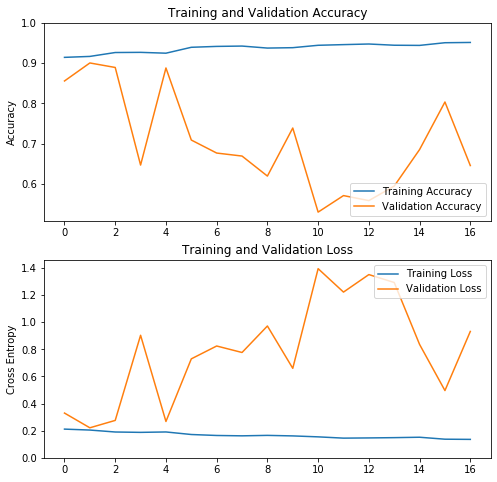

Training Acc:  [0.9144081858407079, 0.9167588495575221, 0.9264380530973452, 0.9268528761061947, 0.9247787610619469, 0.9394358407079646, 0.9416482300884956, 0.9424778761061947, 0.9375, 0.9384679203539823, 0.9444137168141593, 0.9460730088495575, 0.9475940265486725, 0.9445519911504425, 0.9441371681415929, 0.9507743362831859, 0.9514657079646017]



Evaluating model on test set...
Result on test set: 87.95%
73.71% (+/- 9.07%)
Saving CV values to file....
CV values successfully saved!



In [130]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_lowercap = []
history_lowercap = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_lowercap' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_lowercap.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_lowercap.append(scores[1] * 100)
    ii += 1
    
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_lowercap), np.std(cvscores_lowercap)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
scnn_1_train = [0.9514657079646017,  0.9578204950988252, 0.942746508106653,  0.9457889642396947, 0.9486931268398304]

In [0]:
cap_df = pd.DataFrame(columns =['Capacity (bits)', 'CV Train Acc', 'CV Test Acc'] )

In [0]:
cap_df.loc['sCNN_og', 'CV Test Acc'] = 97.157
cap_df.loc['sCNN_og', 'Capacity (bits)'] = 8360
cap_df.loc['sCNN_og', 'CV Train Acc'] = 75.471

cap_df.loc['sCNN_1', 'CV Test Acc'] = np.mean(cvscores_lowercap)
cap_df.loc['sCNN_1', 'Capacity (bits)'] = 2960
cap_df.loc['sCNN_1', 'CV Train Acc'] = np.mean(scnn_1_train)*100


In [142]:
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
sCNN_og,8360,75.471,97.157
sCNN_1,2960,94.9303,73.7071


## our sCNN 1770 bits

In [0]:
###MODEL###

model = Sequential()
# Conv Block 1
model.add(Conv2D(input_shape=(3, 1000, 1), filters=15, kernel_size=(1, 25), strides=(1, 1),
                padding='valid', activation=None))
model.add(Reshape(target_shape=(3, 976, 15, 1)))
# model.add(Dropout(0.5))

# Conv Block 2
model.add(Conv3D(filters=15, kernel_size=(3, 1, 15), padding='valid',
                data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation(keras.backend.square))  # custom squaring activation function
model.add(Flatten())
model.add(Reshape(target_shape=(976, 15, 1)))
# model.add(Dropout(0.5))
# Pooling
model.add(AveragePooling2D(pool_size=(75, 1), strides=(15, 1), data_format='channels_last'))
model.add(Activation(keras.backend.log))  # custom log function

# Classification
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

  # compile the model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [144]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 3, 976, 15)        390       
_________________________________________________________________
reshape_25 (Reshape)         (None, 3, 976, 15, 1)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 1, 976, 1, 15)     690       
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 976, 1, 15)     60        
_________________________________________________________________
activation_25 (Activation)   (None, 1, 976, 1, 15)     0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 14640)             0         
_________________________________________________________________
reshape_26 (Reshape)         (None, 976, 15, 1)      

Run 1...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 21s - loss: 0.2959 - acc: 0.8726 - val_loss: 0.0287 - val_acc: 0.9988

Epoch 00001: val_loss improved from inf to 0.02870, saving model to checkpoints/GRAZ_sCNN_2_run_1.h5
Epoch 2/100
 - 21s - loss: 0.2880 - acc: 0.8802 - val_loss: 0.0566 - val_acc: 0.9813

Epoch 00002: val_loss did not improve from 0.02870
Epoch 3/100
 - 22s - loss: 0.2648 - acc: 0.8934 - val_loss: 0.1002 - val_acc: 0.9701

Epoch 00003: val_loss did not improve from 0.02870
Epoch 4/100
 - 22s - loss: 0.2537 - acc: 0.8963 - val_loss: 0.2085 - val_acc: 0.9142

Epoch 00004: val_loss did not improve from 0.02870
Epoch 5/100
 - 22s - loss: 0.2519 - acc: 0.8988 - val_loss: 0.2278 - val_acc: 0.9055

Epoch 00005: val_loss did not improve from 0.02870
Epoch 6/100
 - 22s - loss: 0.2392 - acc: 0.9036 - val_loss: 0.4871 - val_acc: 0.7861

Epoch 00006: val_loss did not improve from 0.02870
Epoch 7/100
 - 22s - loss: 0.2317 - acc: 0.9087 - val_loss: 0.7549 - val

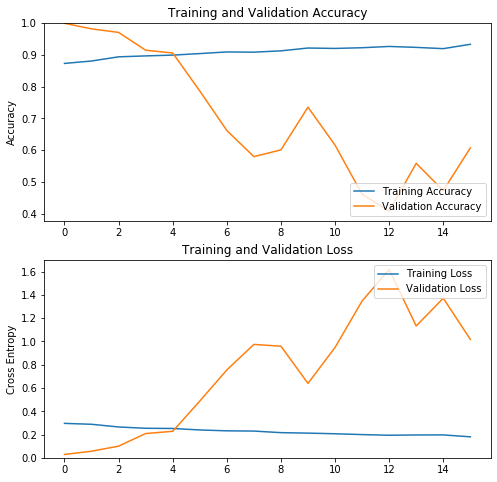

Training Acc:  [0.8726317246183454, 0.880237864790212, 0.8933757433932841, 0.8962799060263915, 0.8987691882915837, 0.9036094593714916, 0.9087263173028949, 0.9080348500010549, 0.9121836537131793, 0.9210344351454075, 0.9197897939592323, 0.9220024893152287, 0.9260129996345772, 0.9231088370097127, 0.9190983266738783, 0.9327893791200709]



Evaluating model on test set...
Result on test set: 61.52%
Run 2...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2870 - acc: 0.8815 - val_loss: 0.0527 - val_acc: 0.9826

Epoch 00001: val_loss improved from inf to 0.05269, saving model to checkpoints/GRAZ_sCNN_2_run_2.h5
Epoch 2/100
 - 22s - loss: 0.2757 - acc: 0.8867 - val_loss: 0.1129 - val_acc: 0.9652

Epoch 00002: val_loss did not improve from 0.05269
Epoch 3/100
 - 22s - loss: 0.2606 - acc: 0.8956 - val_loss: 0.1098 - val_acc: 0.9689

Epoch 00003: val_loss did not improve from 0.05269
Epoch 4/100
 - 22s - loss: 0.2473 - acc: 0.9011 - val_loss: 0.2016 - val_acc: 0.9341



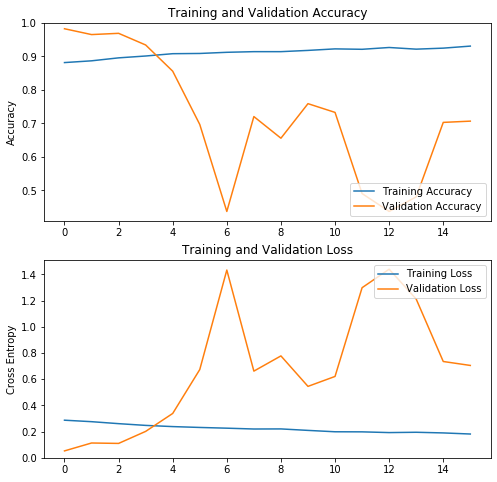

Training Acc:  [0.8814825059434155, 0.886737657350024, 0.8955884387080657, 0.9011201770568418, 0.9080348500175407, 0.9087263173111377, 0.9121836537708798, 0.9141197622094374, 0.9141197621847086, 0.9178536855454037, 0.9224173696831439, 0.9211727285629122, 0.926566173444726, 0.9215876090132569, 0.9246300650391402, 0.9307149772063081]



Evaluating model on test set...
Result on test set: 68.94%
Run 3...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2805 - acc: 0.8816 - val_loss: 0.1387 - val_acc: 0.9552

Epoch 00001: val_loss improved from inf to 0.13868, saving model to checkpoints/GRAZ_sCNN_2_run_3.h5
Epoch 2/100
 - 22s - loss: 0.2675 - acc: 0.8921 - val_loss: 0.1820 - val_acc: 0.9403

Epoch 00002: val_loss did not improve from 0.13868
Epoch 3/100
 - 22s - loss: 0.2561 - acc: 0.8923 - val_loss: 0.6734 - val_acc: 0.6816

Epoch 00003: val_loss did not improve from 0.13868
Epoch 4/100
 - 22s - loss: 0.2444 - acc: 0.8995 - val_loss: 0.7060 - val_acc: 0.6692

E

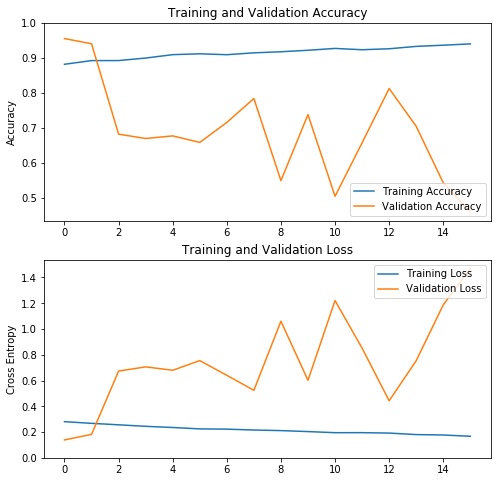

Training Acc:  [0.881620799385649, 0.8921311022648094, 0.8922693957235288, 0.8994606556016665, 0.9091411976460813, 0.9116304798865447, 0.9090029042285765, 0.9143963490939044, 0.9174388052022172, 0.9217259024390045, 0.9269810538126413, 0.9232471304601891, 0.9260129996098484, 0.9327893791200709, 0.9362467155715701, 0.9399806389405081]



Evaluating model on test set...
Result on test set: 79.49%
Run 4...
Train on 7231 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2701 - acc: 0.8913 - val_loss: 0.0396 - val_acc: 0.9863

Epoch 00001: val_loss improved from inf to 0.03957, saving model to checkpoints/GRAZ_sCNN_2_run_4.h5
Epoch 2/100
 - 22s - loss: 0.2553 - acc: 0.8955 - val_loss: 0.1692 - val_acc: 0.9391

Epoch 00002: val_loss did not improve from 0.03957
Epoch 3/100
 - 22s - loss: 0.2415 - acc: 0.9042 - val_loss: 0.4227 - val_acc: 0.8172

Epoch 00003: val_loss did not improve from 0.03957
Epoch 4/100
 - 22s - loss: 0.2367 - acc: 0.9086 - val_loss: 0.4338 - val_acc: 0.8197



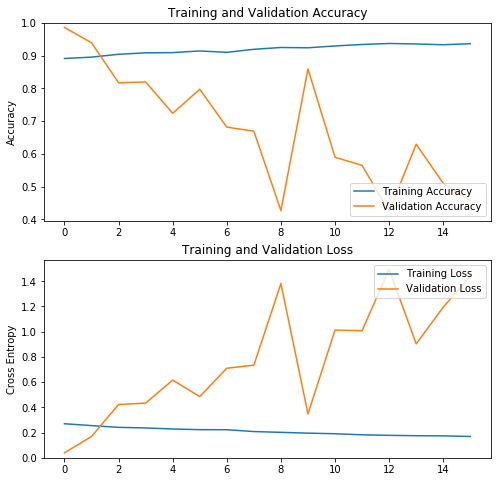

Training Acc:  [0.8913013415042501, 0.895450145282318, 0.9041626331486686, 0.9085880238606613, 0.9092794911130436, 0.9143963490774186, 0.9101092518818459, 0.91937491359956, 0.9249066519483361, 0.9240768912289914, 0.9296086295447958, 0.934172313699022, 0.9372147697743629, 0.9356935417284495, 0.9333425529714343, 0.9365233024560371]



Evaluating model on test set...
Result on test set: 66.50%
Run 5...
Train on 7232 samples, validate on 804 samples
Epoch 1/100
 - 22s - loss: 0.2615 - acc: 0.8924 - val_loss: 0.1887 - val_acc: 0.9303

Epoch 00001: val_loss improved from inf to 0.18868, saving model to checkpoints/GRAZ_sCNN_2_run_5.h5
Epoch 2/100
 - 22s - loss: 0.2437 - acc: 0.9033 - val_loss: 0.3624 - val_acc: 0.8557

Epoch 00002: val_loss did not improve from 0.18868
Epoch 3/100
 - 22s - loss: 0.2344 - acc: 0.9089 - val_loss: 0.4542 - val_acc: 0.8197

Epoch 00003: val_loss did not improve from 0.18868
Epoch 4/100
 - 22s - loss: 0.2342 - acc: 0.9082 - val_loss: 0.3051 - val_acc: 0.8818

Epo

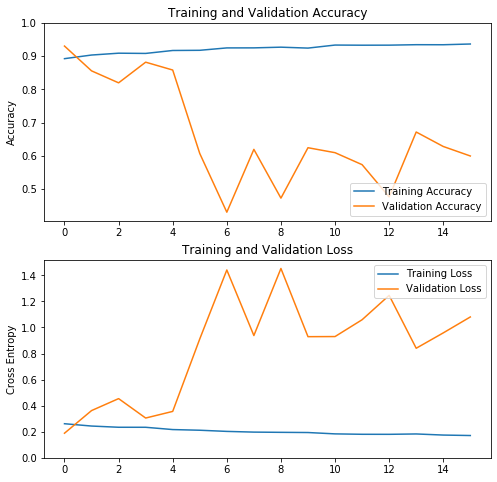

Training Acc:  [0.8924225663716814, 0.9033462389380531, 0.9088772123893806, 0.9081858407079646, 0.9170353982300885, 0.9175884955752213, 0.9247787610619469, 0.9249170353982301, 0.9269911504424779, 0.9242256637168141, 0.9333517699115044, 0.9329369469026548, 0.933075221238938, 0.9344579646017699, 0.9343196902654868, 0.9365320796460177]



Evaluating model on test set...
Result on test set: 80.58%
71.41% (+/- 7.45%)
Saving CV values to file....
CV values successfully saved!



In [146]:
from sklearn.model_selection import StratifiedKFold
from models import LSTM
import datetime
from keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping


# define KFOLD-fold cross validation test harness
kfold = StratifiedKFold(n_splits = KFOLD, shuffle = True, random_state = SEED)
cvscores_2 = []
history_2 = []
ii = 1
for train, test in kfold.split(x_subject, y_subject[:, 0]):
    print('Run ' + str(ii) + '...')
    # create callbacks
    model_name_str = 'GRAZ_sCNN_2' + \
                     '_run_' + str(ii)

    # initialize and create the model
    
    # fit model. If you specify monitor=True, then the model will create callbacks
    # and write its state to a HDF5 file
    train_data =  [x_subject[train], y_subject[train]]
    monitor_index = 'val_loss'
    h = run_model(model, model_name_str,100, train_data, 0.1, 256, monitor_index)
    save_model(model, model_name_str, '')
    draw_graphs(h)
    history_2.append(h)

    history.append(h)
    print ('Training Acc: ', h.history['acc'])
    print ('\n\n')
    # evaluate the model
    print('Evaluating model on test set...')
    scores = model.evaluate(x_subject[test], y_subject[test], verbose = 0)
    print("Result on test set: %.2f%%" % ( scores[1] * 100))
    cvscores_2.append(scores[1] * 100)
    ii += 1
    
    
try:
  # print some evaluation statistics and write results to file
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_2), np.std(cvscores_2)))
  cv_all_subjects = np.asarray(cvscores)
  print('Saving CV values to file....')
  np.savetxt('GRAZ_CV_' + 'LSTM_' + str(DROPOUT) + 'do'+'.csv', 
              cv_all_subjects, delimiter = ',', fmt = '%2.4f')
  print('CV values successfully saved!\n')
except:
  print ('could not save')

In [0]:
scnn_2_train = [0.9327893791200709, 0.9307149772063081, 0.9399806389405081, 0.9365233024560371, 0.936532079646017]

In [149]:

cap_df.loc['sCNN_og', 'CV Train Acc'] = 97.157
cap_df.loc['sCNN_og', 'CV Test Acc'] = 75.471
cap_df.loc['sCNN_2', 'CV Test Acc'] = np.mean(cvscores_2)
cap_df.loc['sCNN_2', 'Capacity (bits)'] = 1770
cap_df.loc['sCNN_2', 'CV Train Acc'] = np.mean(scnn_1_train)*100
cap_df

,Capacity (bits),CV Train Acc,CV Test Acc
sCNN_og,8360,97.157,75.471
sCNN_1,2960,94.9303,73.7071
sCNN_2,1770,94.9303,71.4067
